In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import os

# Puede utilizar esta extension si trabaja en colaboratory:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/ejercicio')

In [ ]:
# cargar con internet
# raw_data_path = 'https://raw.githubusercontent.com/NicoCaro/DataScienceLab/master/ejercicios/ejercicio%203/data/news.csv'
# raw_df = pd.read_csv(raw_data_path, index_col=0)

# P1. Carga y Exploracion

## 1.Crear columna delta_time 

In [69]:
# directorio PRSA_Data 
list_dir = os.listdir('PRSA_Data')
# cargar todos los csv como un mismo dataframe
data = pd.concat([pd.read_csv('PRSA_Data/'+list_dir[i], index_col=0) for i in range(len(list_dir))],
                 ignore_index=True, sort=False)

In [70]:
# Agregar columna 'delta_time' al dataframe data, esta columna tiene
# la diferencia de tiempo con la fecha inicial '2013, 3, 1, 0', 
# con dtype: timedelta64[ns]
data['delta_time'] = list(pd.to_datetime(data[data.columns[:4]])-pd.Timestamp(2013, 3, 1, 0))

## 2. Analizar  correlaciones de presencia de valores faltantes en las diferentes estaciones. Generar visualizaciones y discutir

In [71]:
# lista de contaminantes
var_cont = ['PM2.5', 'PM10', 'SO2', 'NO2','CO', 'O3']
# lista de estaciones
station_list = data['station'].unique()
# data frame para cada contaminante 
list_corr = [(pd.DataFrame({station: list(data[data['station']==station][contam]) 
                           for station in station_list})) for contam in var_cont]

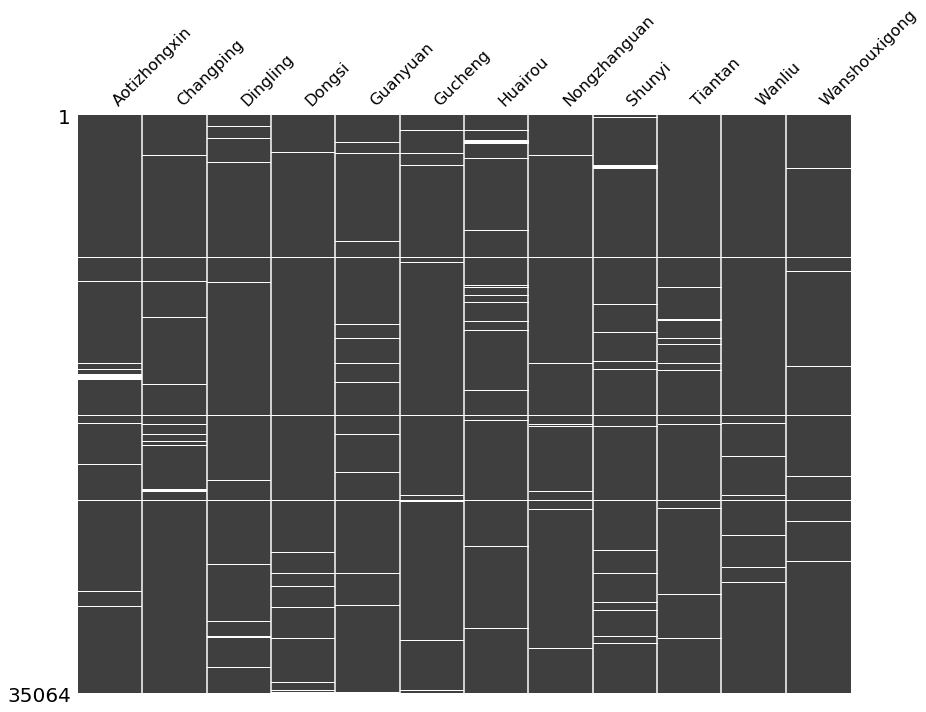

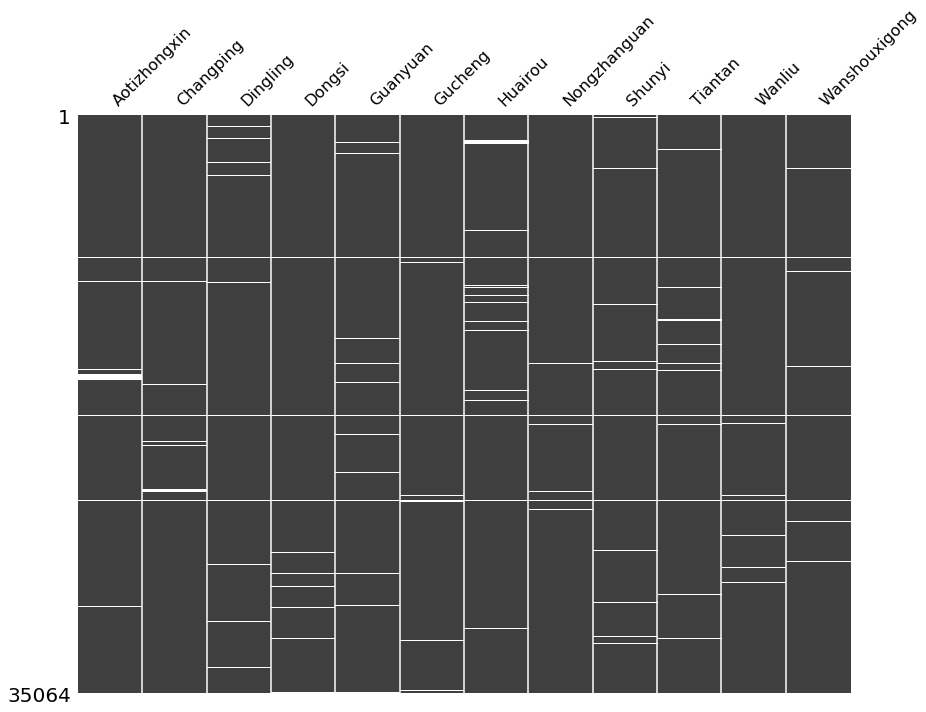

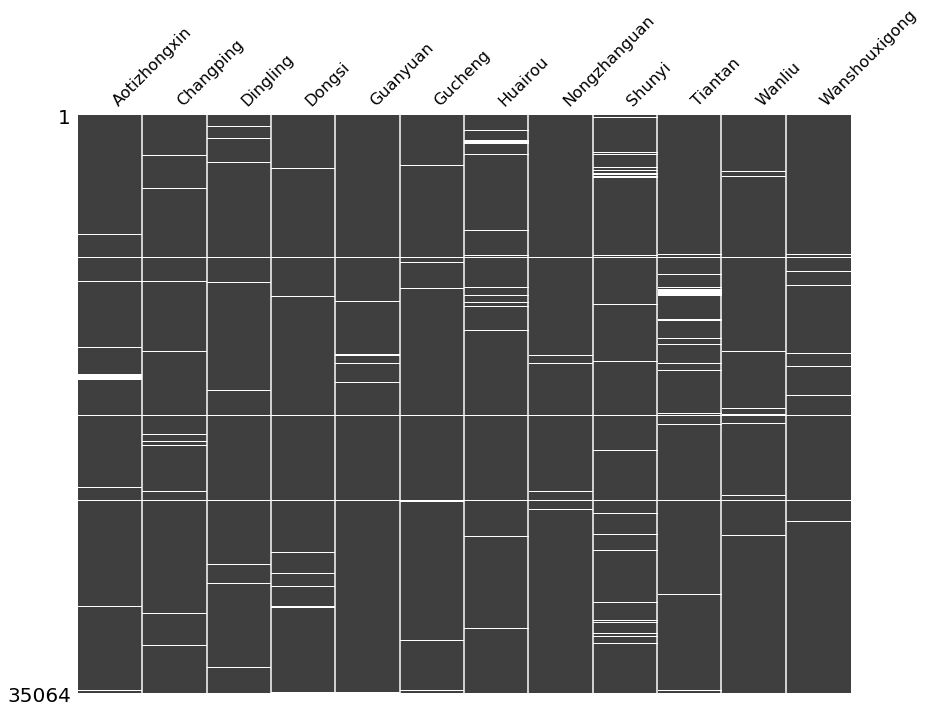

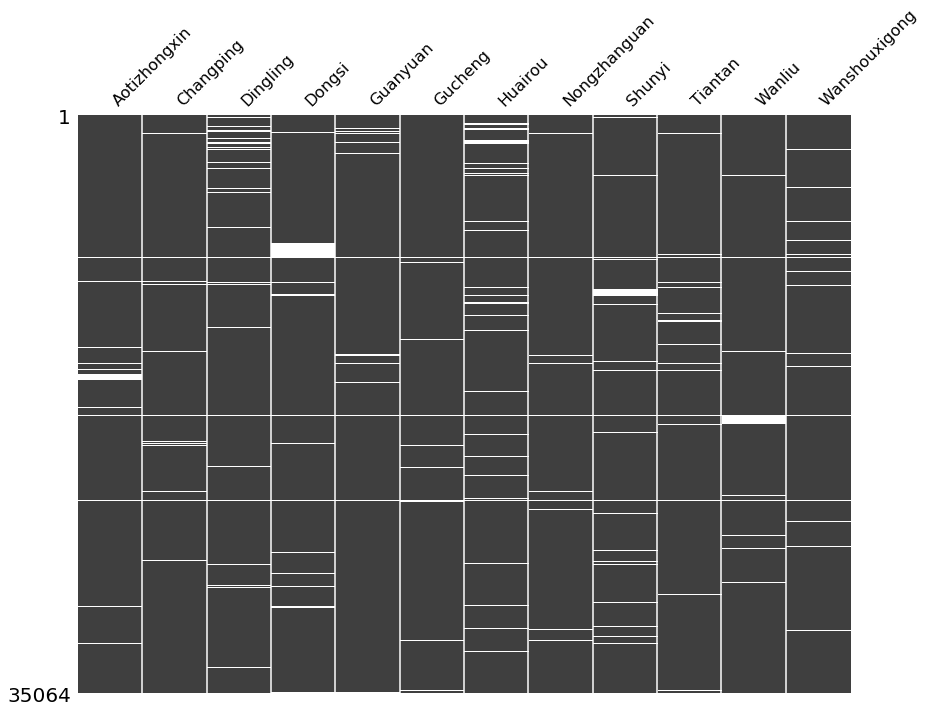

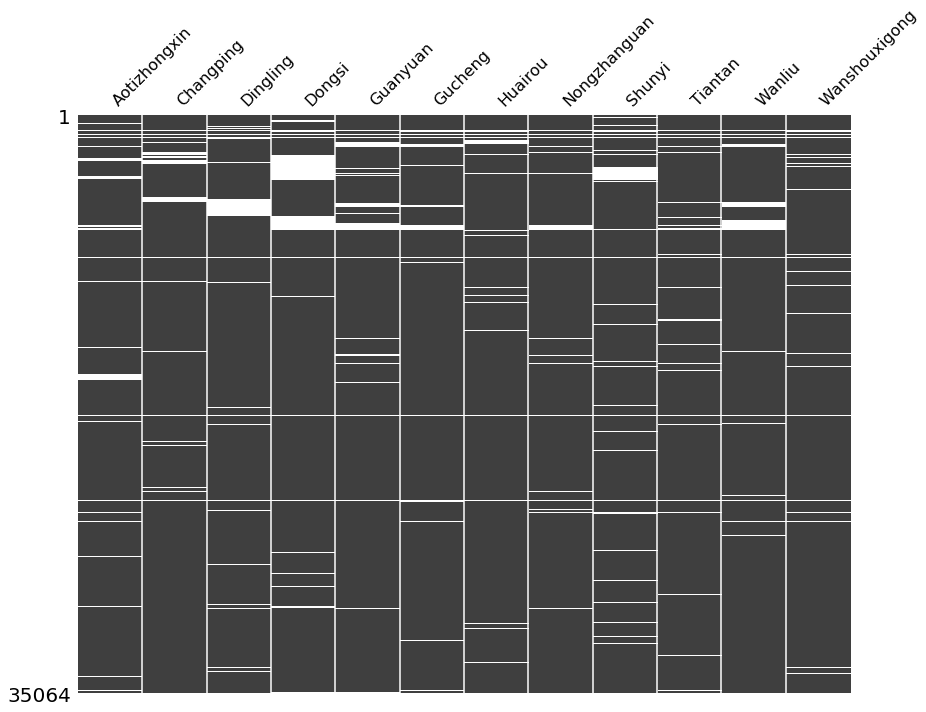

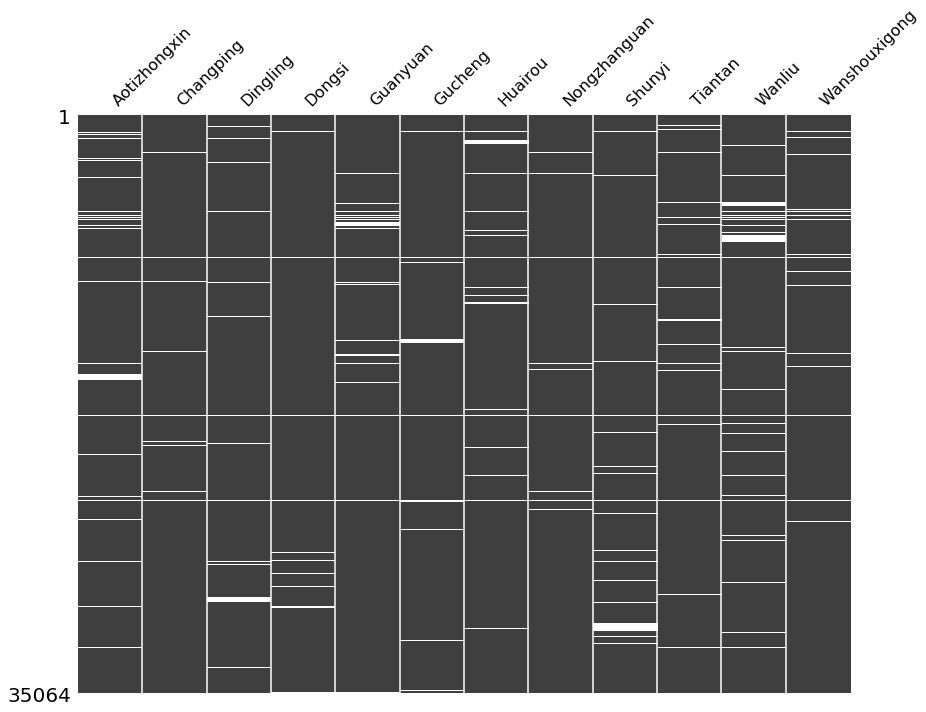

In [72]:
for index in range(6): 
    # graficar valores faltantes
    fig, ax = plt.subplots(figsize=[13, 10])
    # se grafica para cada axis
    cont = var_cont[index] 
    # Graficos para datos faltantes
    msno.matrix(list_corr[index],ax = ax, sparkline=False)
#     axis.set_axis_off()
#     axis.set_title(cont, fontsize=15)
    # Se ajusta el espaciado exterior de la figura
    fig.tight_layout()
#     plt.savefig('Valores_faltantes_' + cont + '.jpg', dpi=50)

In [80]:
# ver porcentaje valores faltantes en estas columnas 
for i in range(len(var_cont)):
    cont = var_cont[i]
    cont_matrix = list_corr[i]
    total = cont_matrix.shape[0] * cont_matrix.shape[1]
    print('Valores faltantes en ', cont,': ',(cont_matrix.isnull().sum().sum() / total)*100, '%')

Valores faltantes en  PM2.5 :  2.0769164955509924 %
Valores faltantes en  PM10 :  1.5326735873450452 %
Valores faltantes en  SO2 :  2.143936801277664 %
Valores faltantes en  NO2 :  2.8794965396608108 %
Valores faltantes en  CO :  4.9198132937866 %
Valores faltantes en  O3 :  3.1554205643014677 %


### En la anterior visualización se puede notar que los valores faltantes
### se observa que los valores faltantes para PM10 tambien lo son para 
### el resto de los contaminantes, calculamos el porcentaje de filas para 
### las que esta observacion es cierta

In [53]:
# ver porcentaje valores faltantes las filas de valores faltantes
# de la columna PM10
(data[var_cont][data['PM10'].isnull()].isnull().sum() / 
 data[var_cont][data['PM10'].isnull()].shape[0])*100

PM2.5     96.650644
PM10     100.000000
SO2       80.942782
NO2       81.625058
CO        82.322841
O3        77.903551
dtype: float64

### Como el porcentaje es mayor a 80% en 4 de la 5 columnas
### podria eliminarse todas las filas con datos faltantes 
### asociados a PM10 con la siguiente celda, pero de rompería la 
### estructura de serie de tiempo.

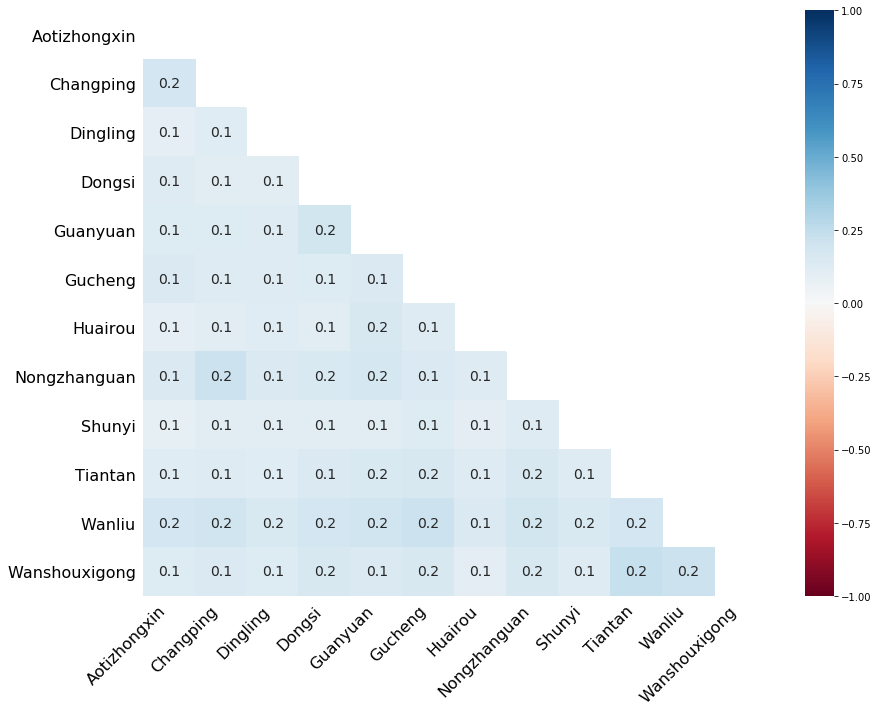

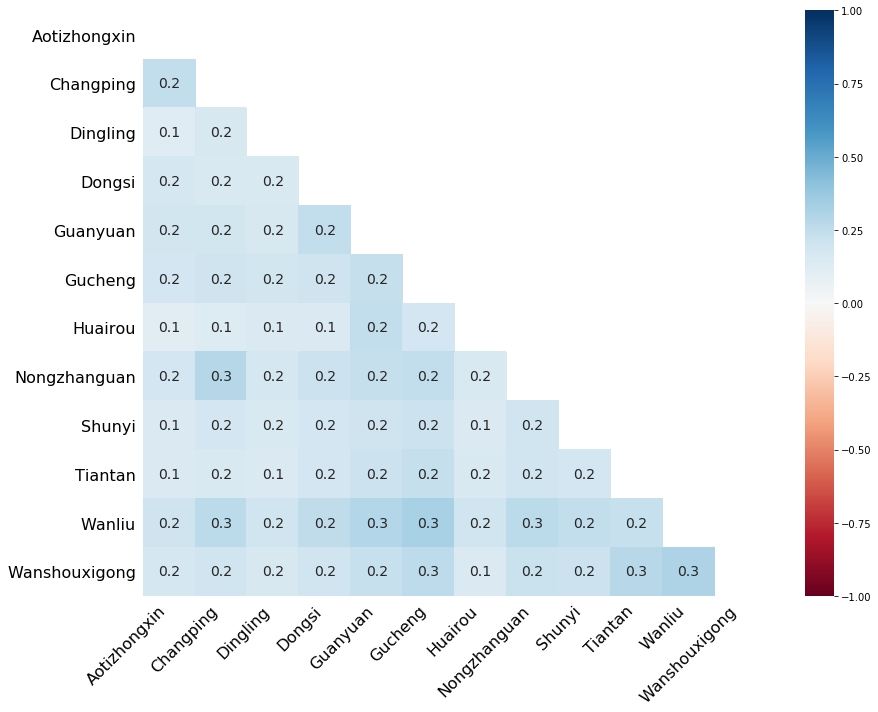

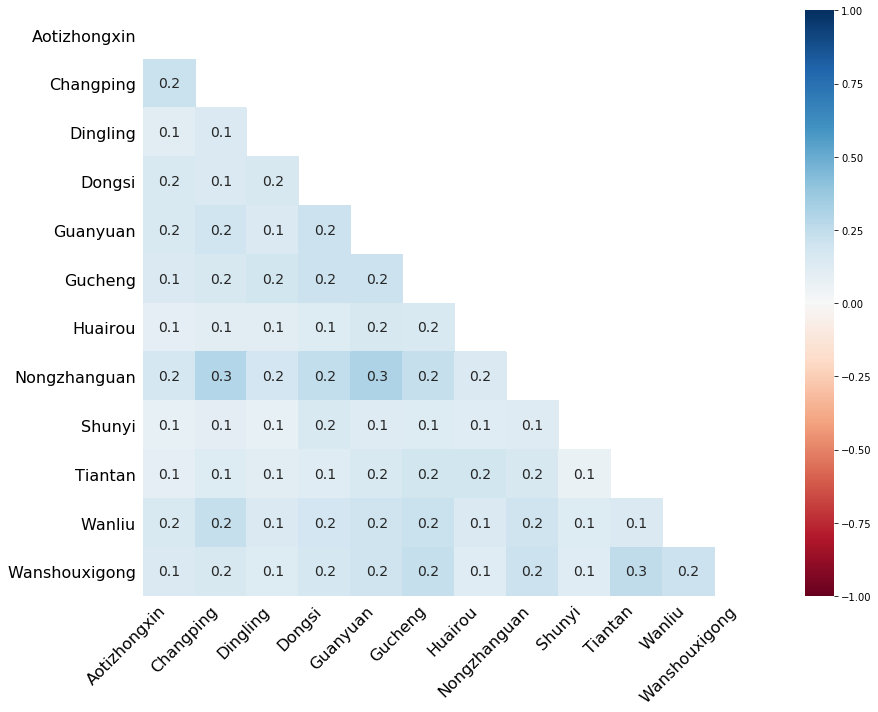

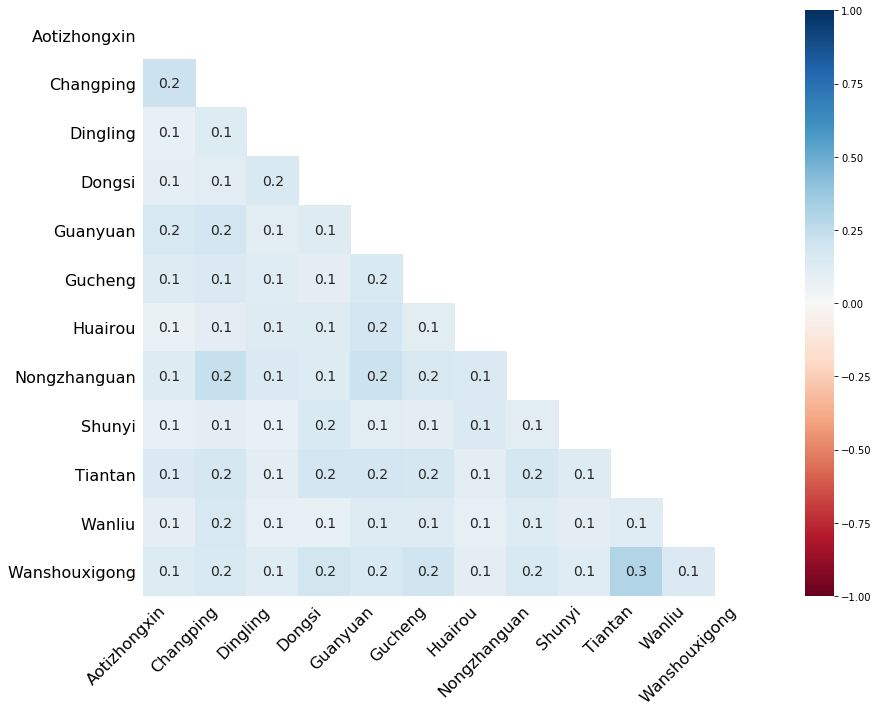

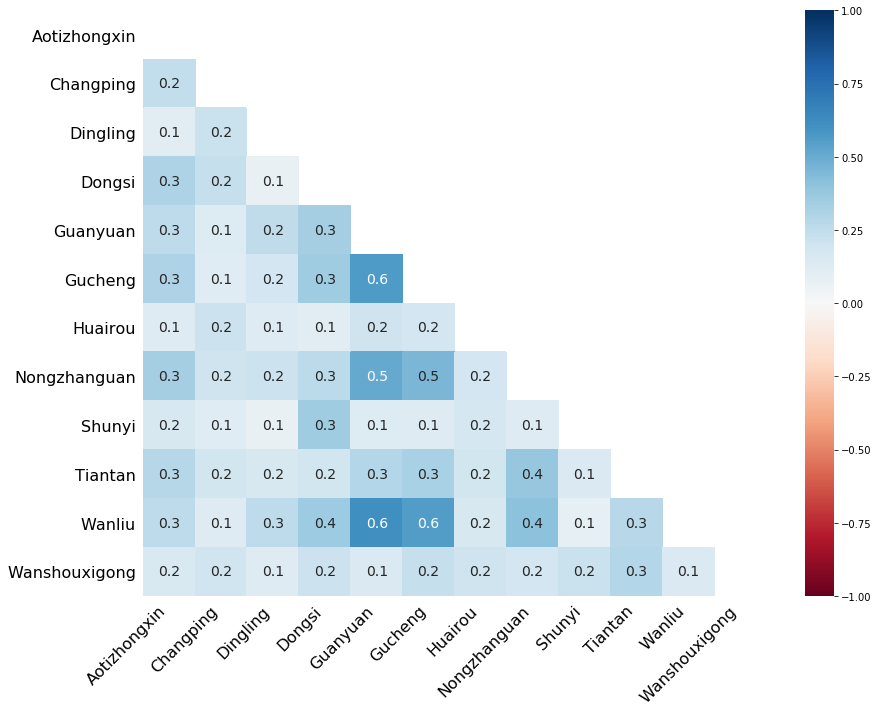

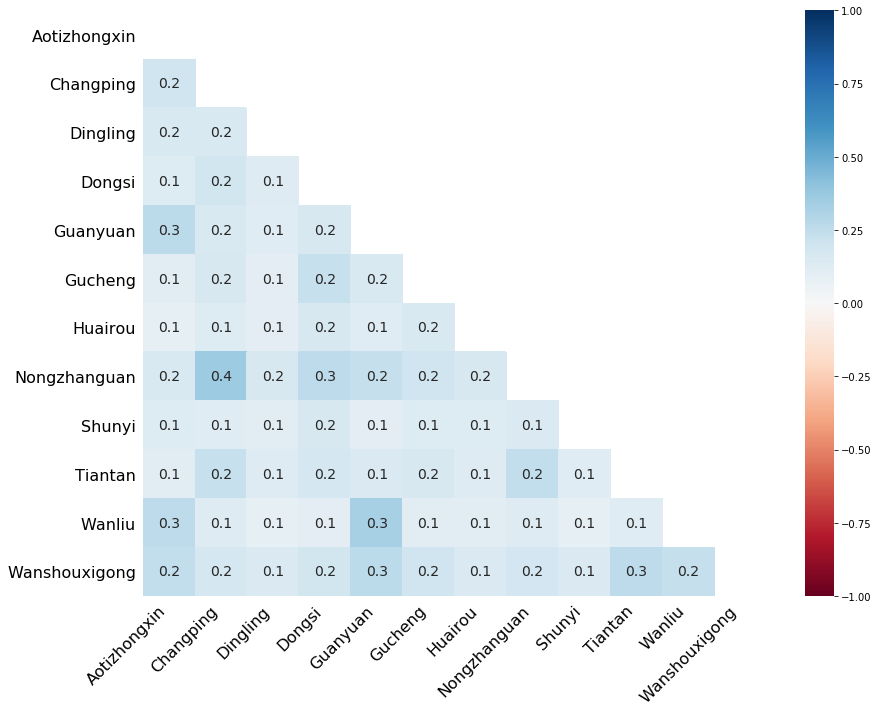

In [83]:
for index in range(6): 
    # graficar valores faltantes
    fig, ax = plt.subplots(figsize=[13, 10])
    # se grafica para cada axis
    cont = var_cont[index] 
    # Graficos para datos faltantes
    msno.heatmap(list_corr[index],ax = ax)
#     axis.set_axis_off()
#     axis.set_title(cont, fontsize=15)
    # Se ajusta el espaciado exterior de la figura
    fig.tight_layout()
    plt.savefig('Valores_faltantes_Heat_map_' + cont + '.jpg', dpi=50)

## 3. En las columnas de contaminantes, rellene los valores faltantes mediante interpolacion. Pruebe diferentes metodos de interpolacion, seleccione un y fundamente su eleccion.

In [84]:
data[var_cont] = data[var_cont].interpolate(method='linear')

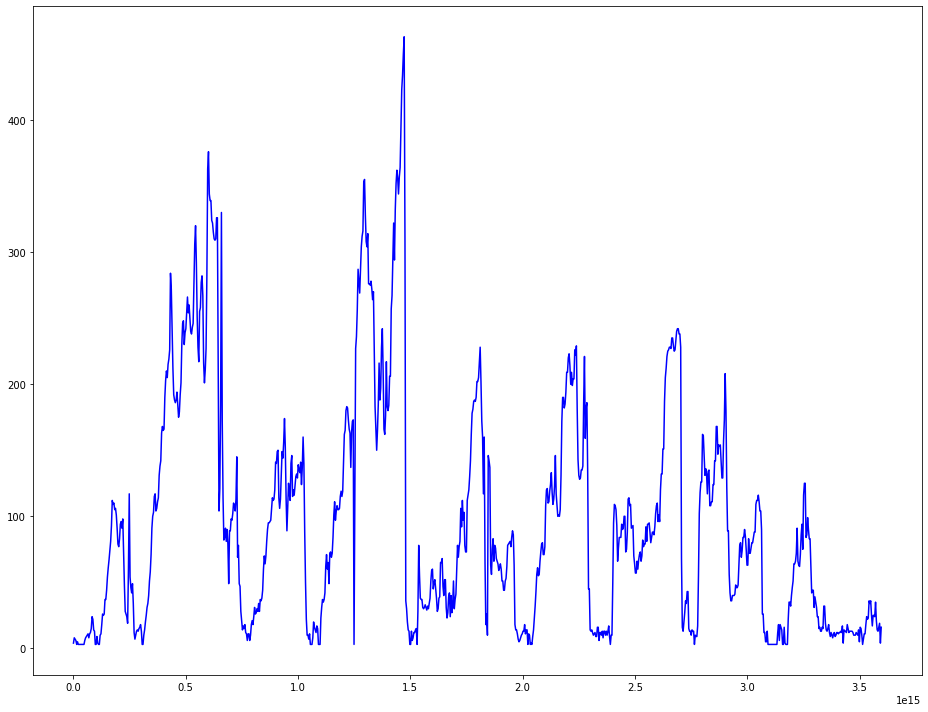

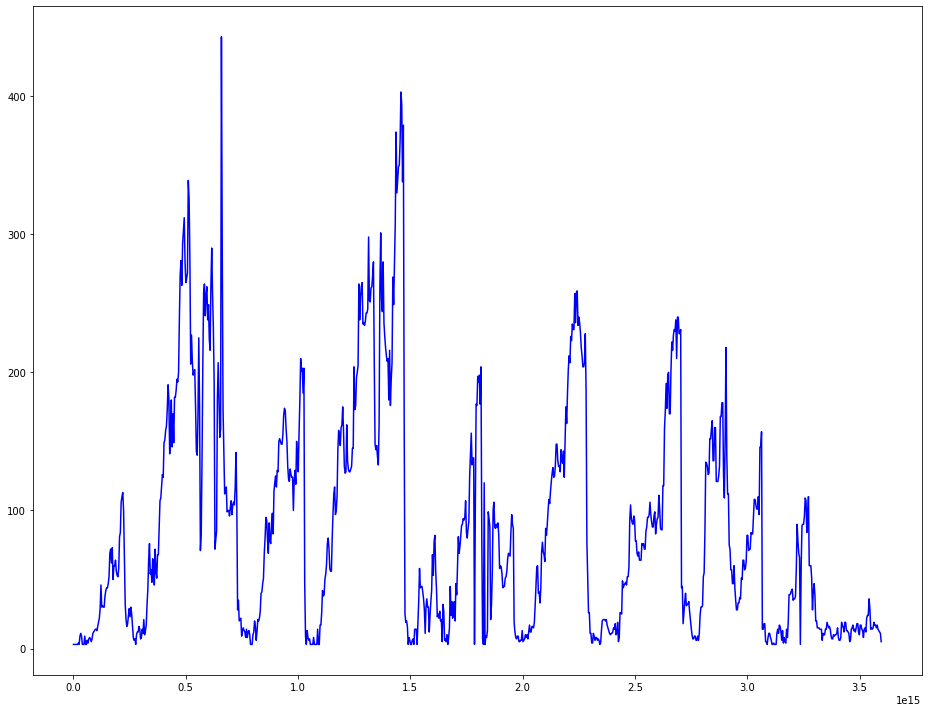

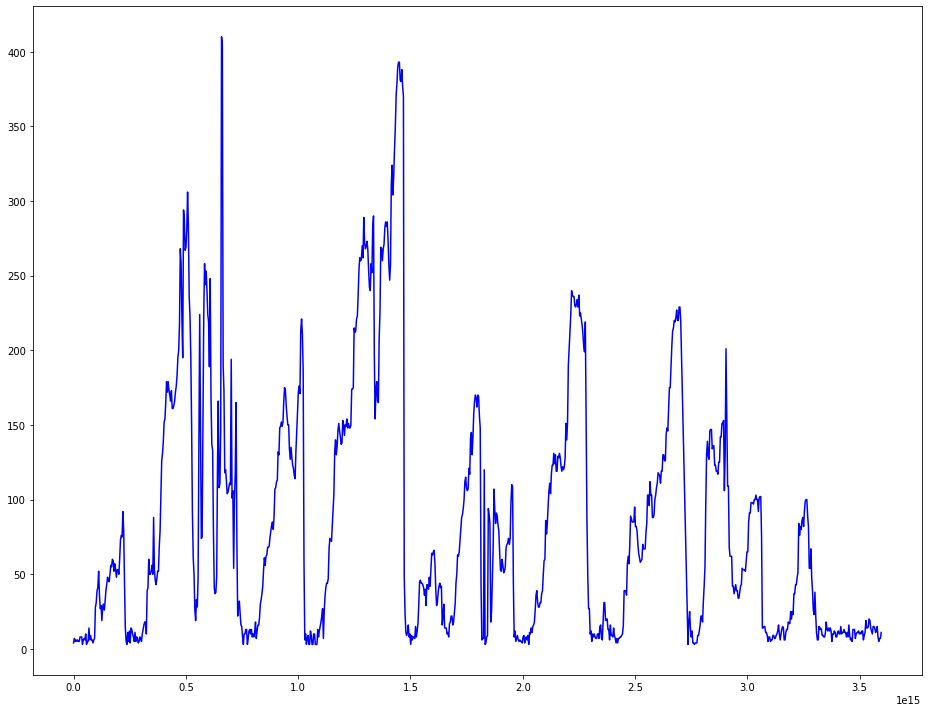

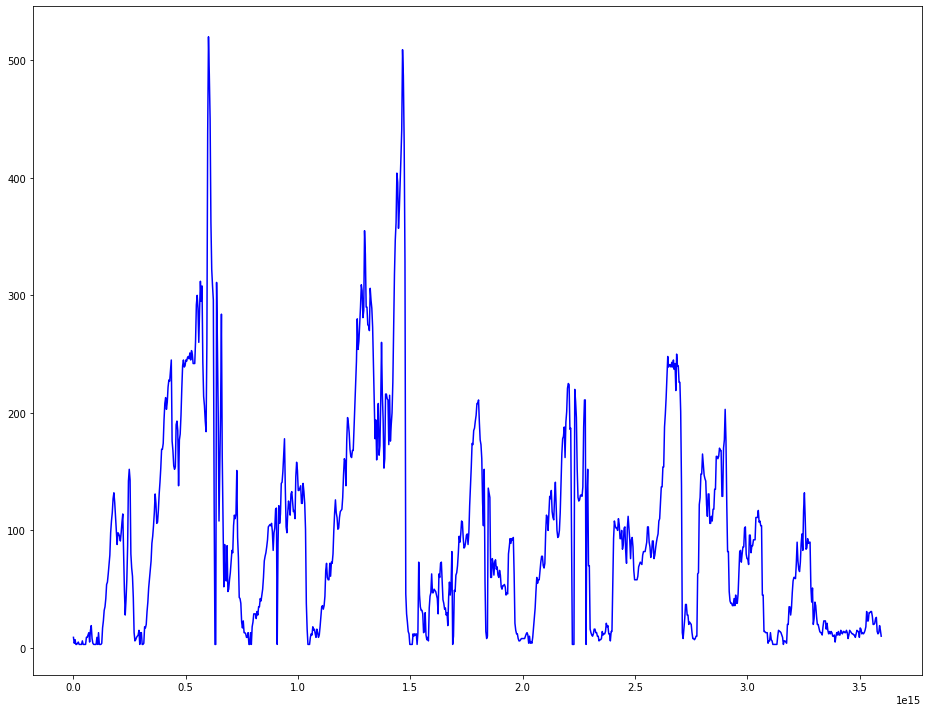

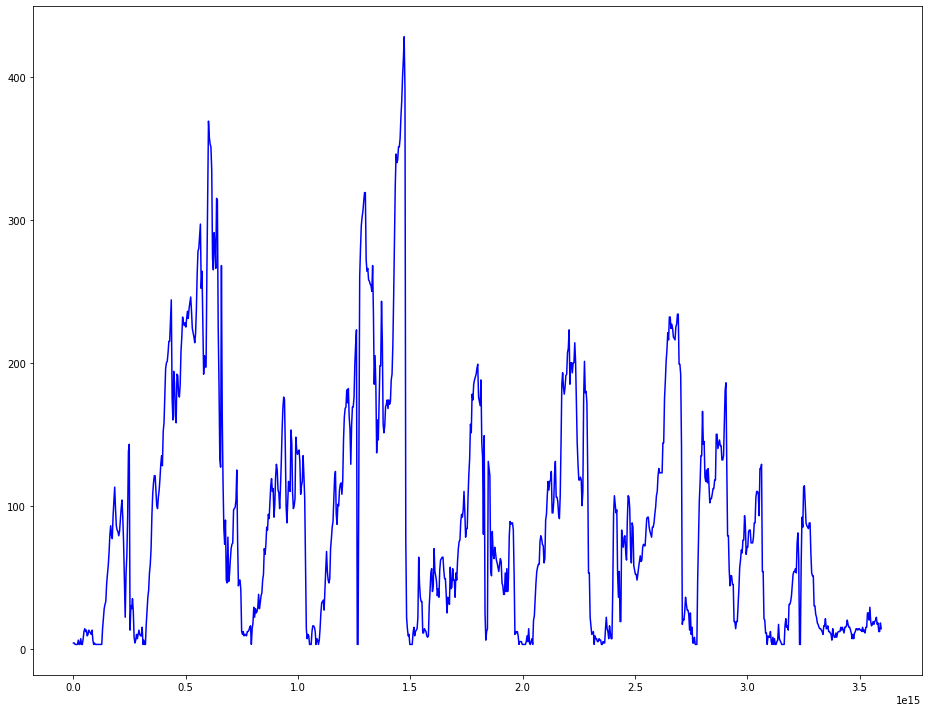

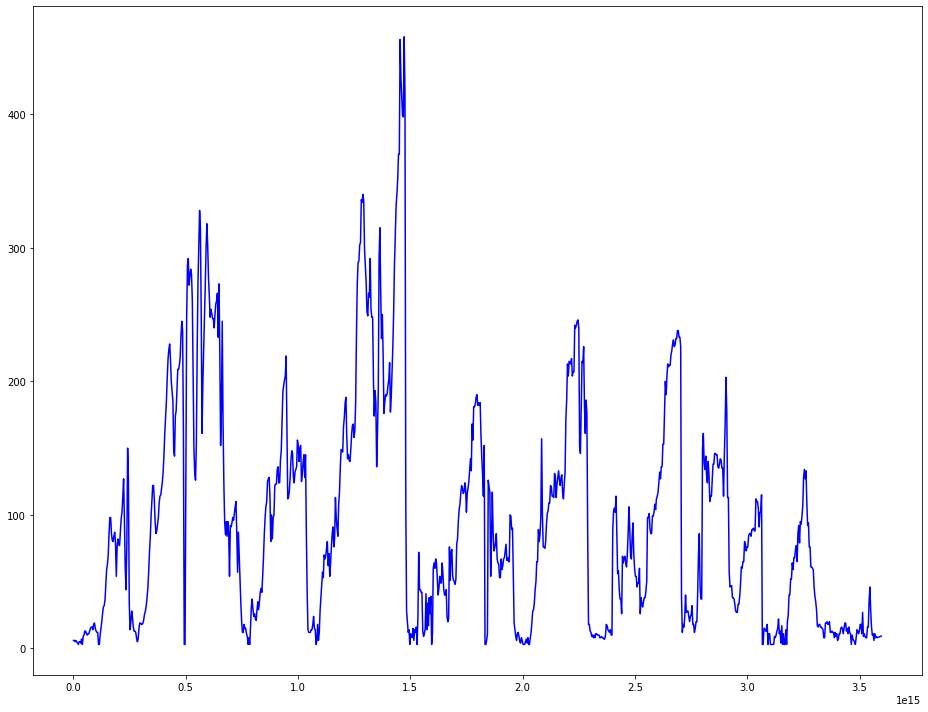

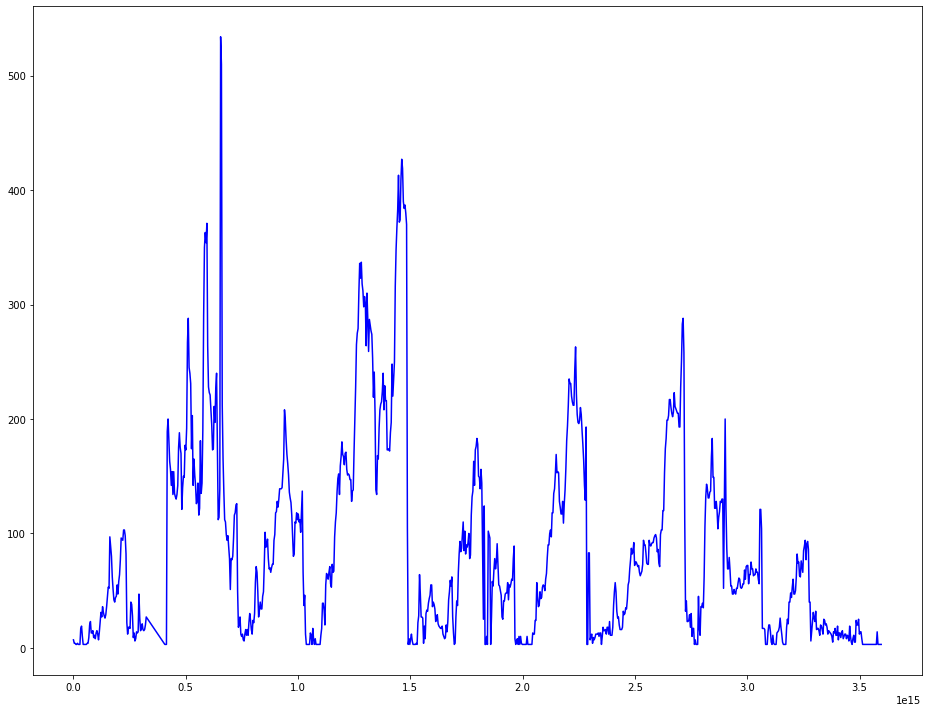

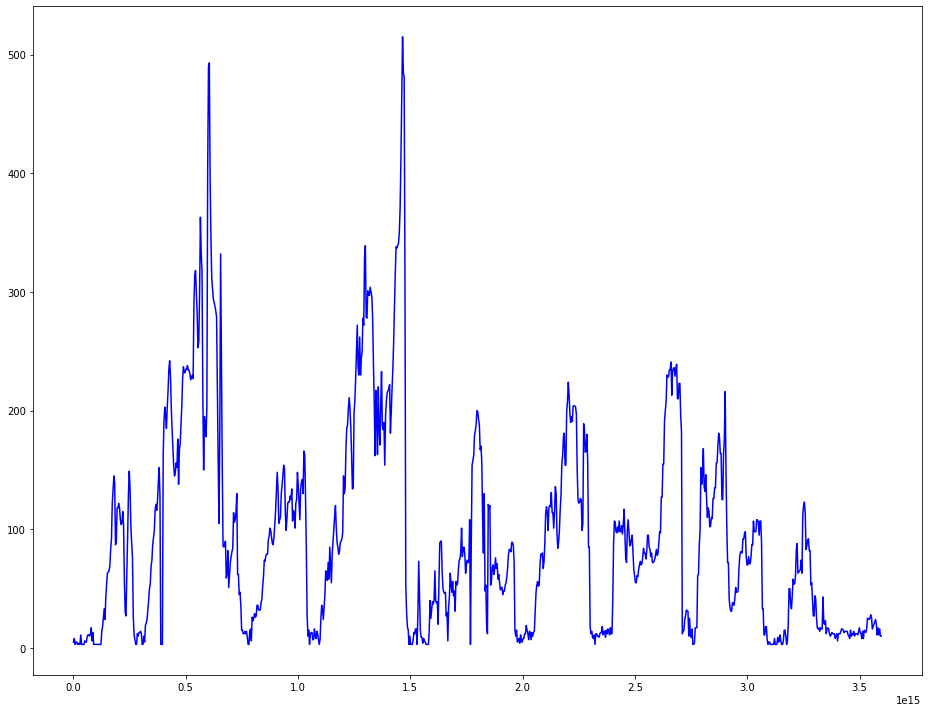

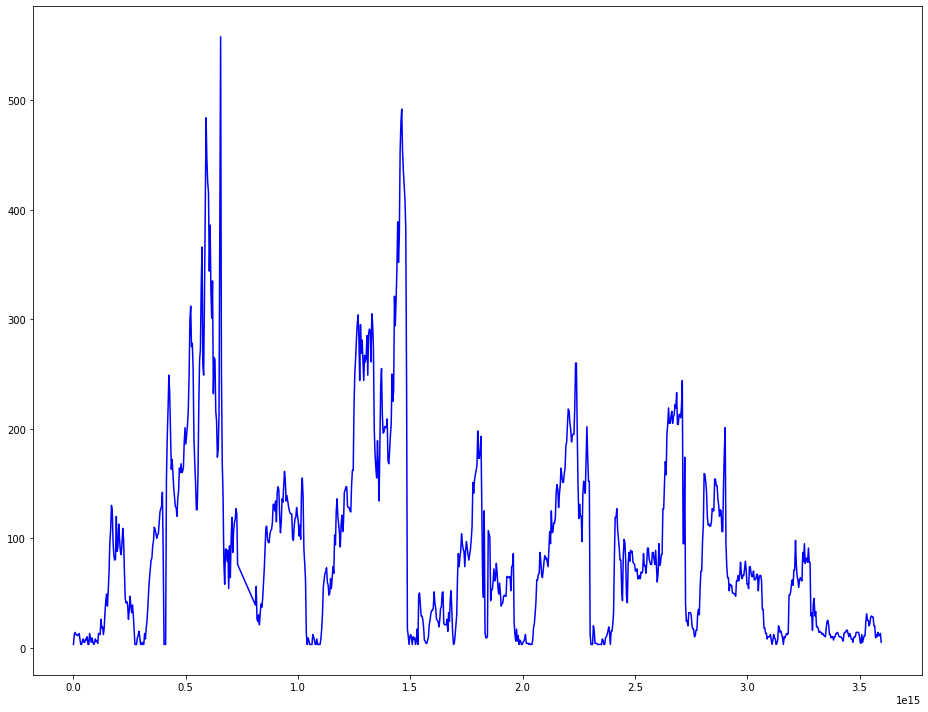

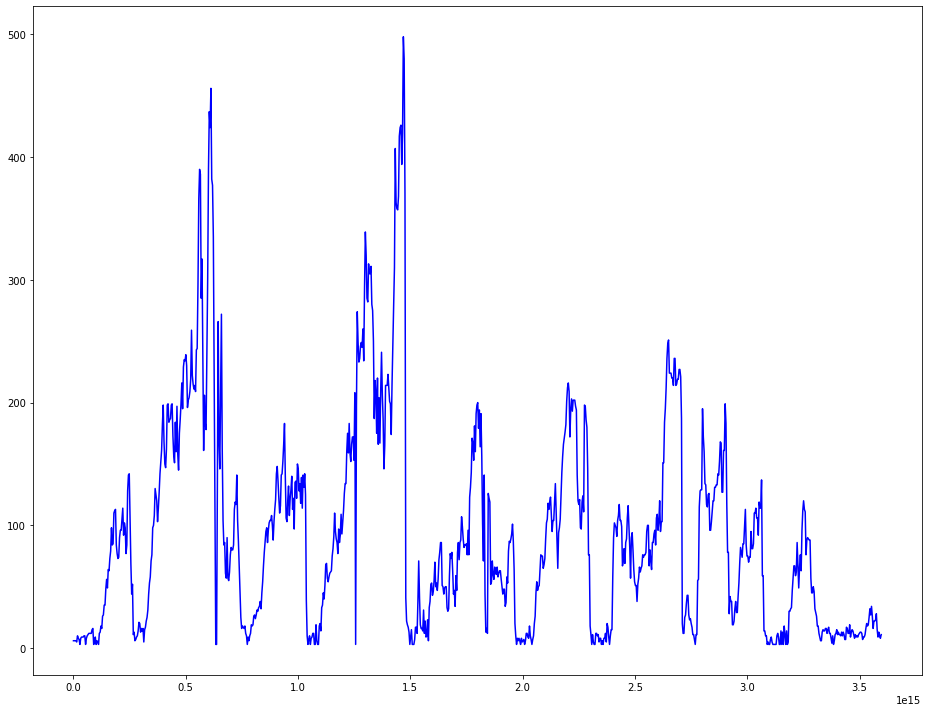

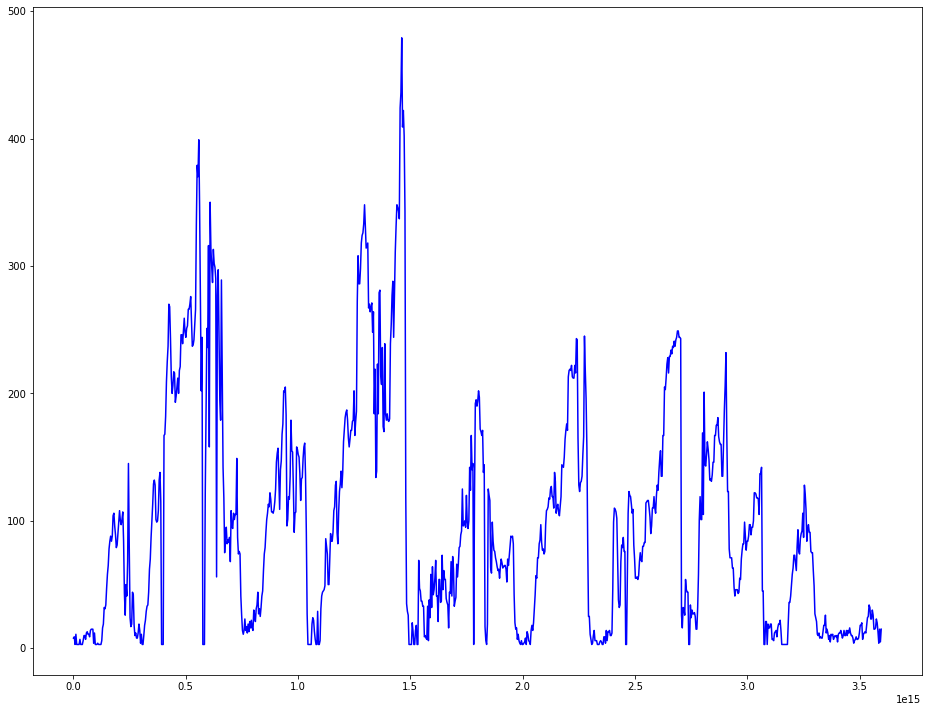

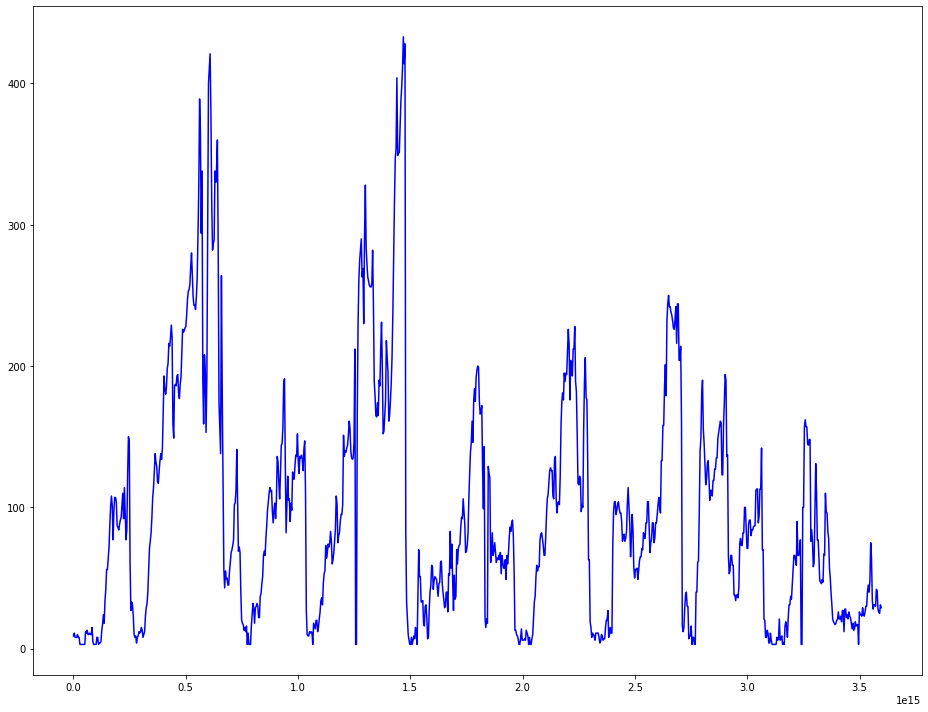

In [86]:
for station in station_list:
    fig, ax = plt.subplots(figsize=[13, 10])
    # se grafica para cada axis
    plt.plot(data[data['station'] == station]['delta_time'][:1000],
         data[data['station'] == station]['PM2.5'][:1000], 'b-')
    fig.tight_layout()
#     plt.savefig('Valores_faltantes_' + cont + '.jpg', dpi=50)

### en las restantes columnas el porcentaje de valores restantes
### es bajo (<0.1), excepto en la columna wd, por lo que se considera
### eliminar la columna wd y el resto de valores faltantes si es necesario

## 4. Analice las correlaciones para cada contaminantes en las diferentes estaciones. Genere visualizaciones, discuta lo observado y seleccione el contaminante que tenga el menor promedio de correlacion entre estaciones. Para dicho contaminante, seleccione las tres estaciones que tengan el promedio de correlacion mas alto.

### Se genera un heatmap de correlaciones para cada contaminante

In [87]:
station_list = data['station'].unique()
list_corr = [(pd.DataFrame({station: list(data[data['station']==station][contam]) 
                           for station in station_list})).corr() for contam in var_cont]

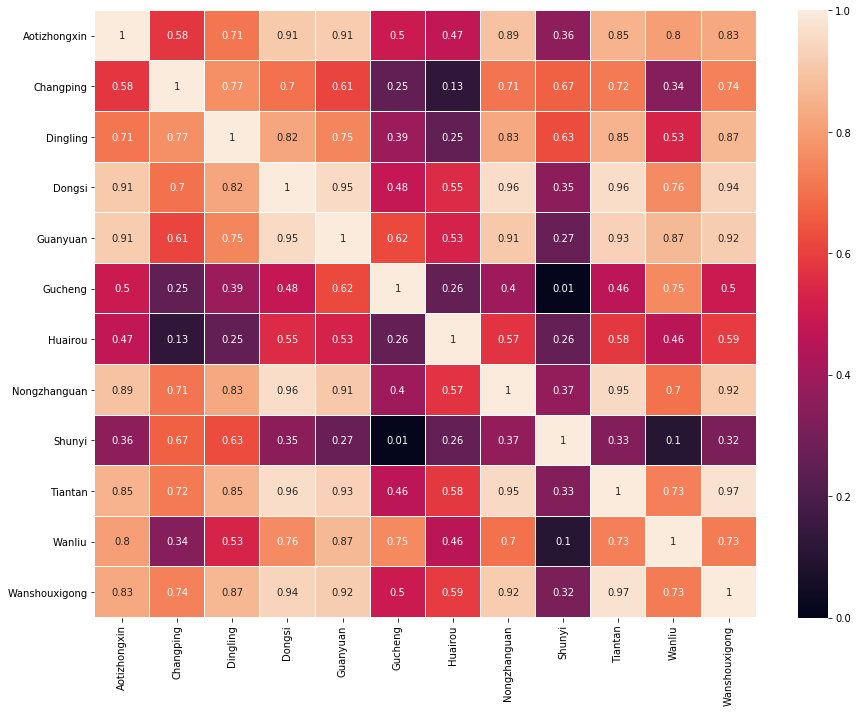

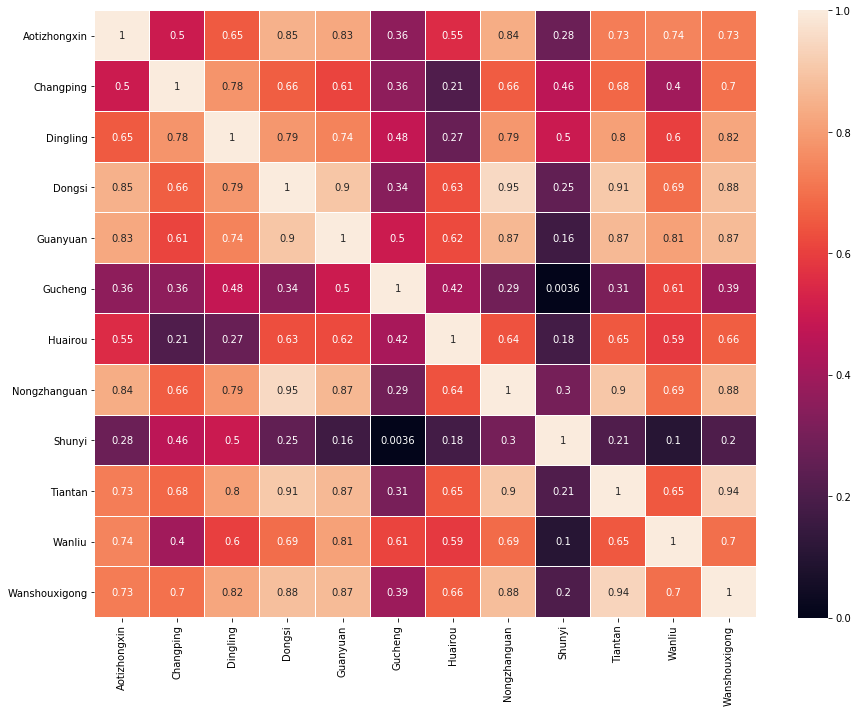

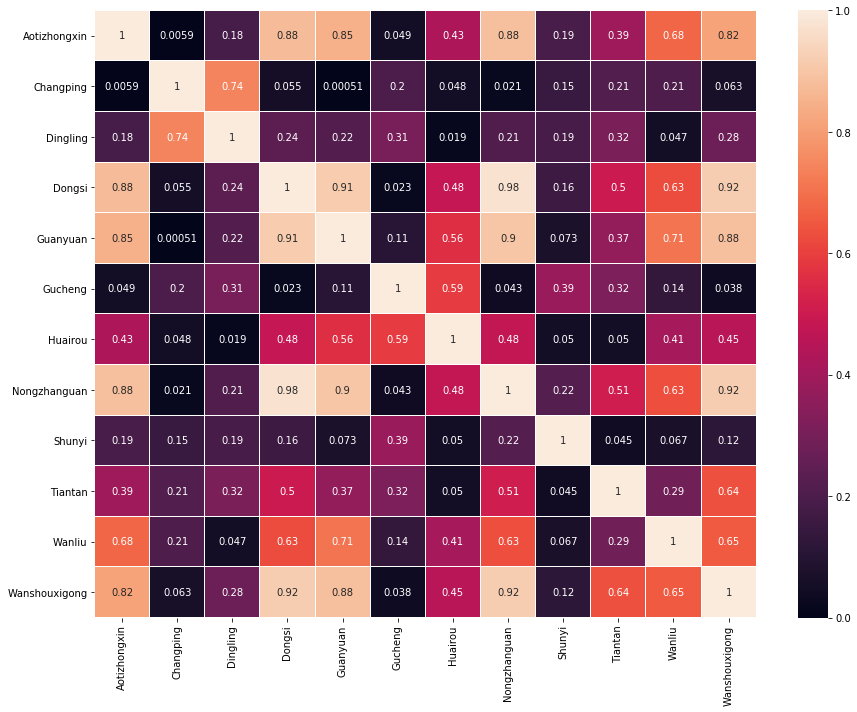

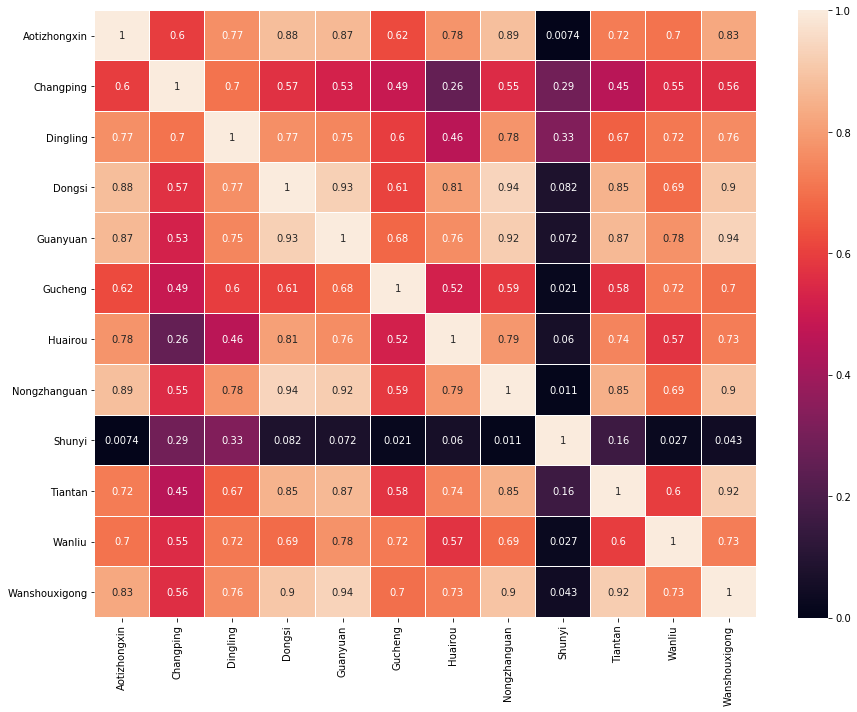

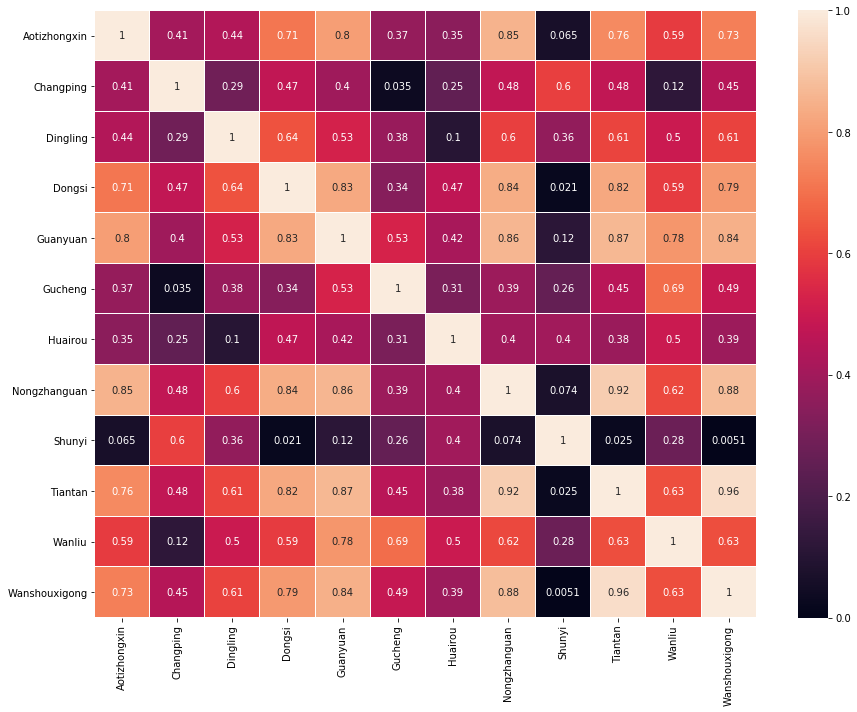

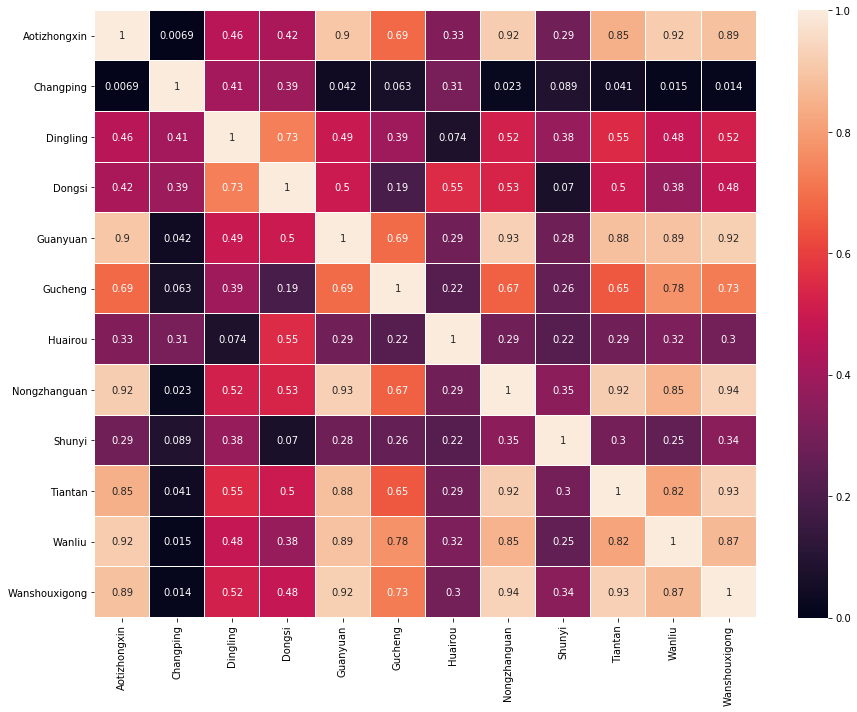

In [89]:
for i in range(len(list_corr)):
    corrmat = list_corr[i].corr()
    fig, ax = plt.subplots(figsize=[13, 10])
    sns.heatmap(abs(corrmat), vmin=0, vmax=1, linewidths=.01, annot=True)
    fig.tight_layout()
    plt.savefig('Correlacion_' + var_cont[i] + '.jpg', dpi=50)

### se observa que el contaminante SO2 una gran cantidad de colores 
### oscuros, por lo que se presume que tiene el menor promedio de 
### correlacion, se procede a calcular los promedios.

In [92]:
promedios = pd.Series({var_cont[i]:list_corr[i].mean().mean() for i in range(len(var_cont))})
promedios

PM2.5    0.889084
PM10     0.847810
SO2      0.821306
NO2      0.760032
CO       0.820665
O3       0.881163
dtype: float64

### Como fue observado, NO2 tiene el menor promedio de correlacion, ahora 
### se calculan las tres estaciones con el mayor promedio de correlación 

In [93]:
corrmat = list_corr[var_cont.index('NO2')]
((corrmat.abs().sum()-1)/(len(corrmat)-1)).nlargest(3)

Guanyuan         0.797416
Wanshouxigong    0.794152
Nongzhanguan     0.780184
dtype: float64

### Las estaciones elegidas fueron: Tiantan,  Wanshouxigong y Nongzhanguan

In [60]:
contam = 'CO'
choice_stations = ['Tiantan', 'Wanshouxigong', 'Nongzhanguan']

## 5. Descomponga en una tendencia, una señal periodica y su residuo; la señal del contaminante seleccionado en cada una de las 3 estaciones seleccionadas. Genere visualizaciones, discuta lo observado ademas de explicar el comportamiento de dicha funcion.

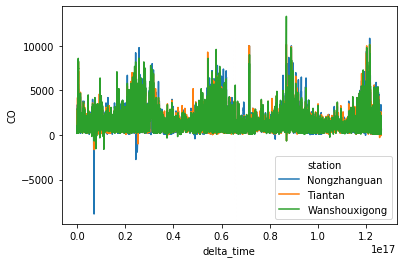

In [61]:
# Plot the responses for different events and regions
sns.lineplot(x='delta_time', y=contam,
             hue='station', data=data[(data['station'] == choice_stations[0])
                                      |(data['station'] == choice_stations[1])
                                      |(data['station'] == choice_stations[2])])

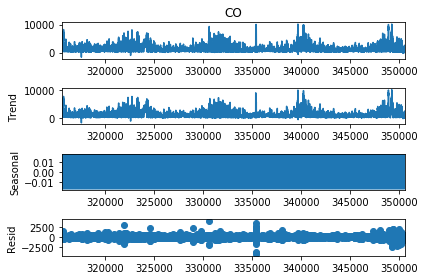

In [62]:
station_0 = seasonal_decompose(data[data['station']==choice_stations[0]]['CO'],
                               model='additive', period=2)
station_0.plot()
plt.show()

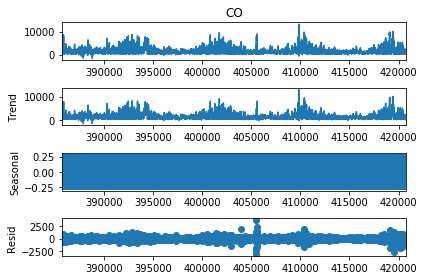

In [63]:
station_1 = seasonal_decompose(data[data['station']==choice_stations[1]]['CO'],
                               model='additive', period=2)
station_1.plot()
plt.show()

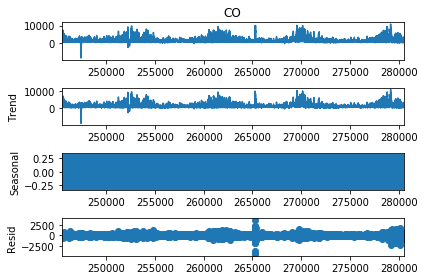

In [64]:
station_2 = seasonal_decompose(data[data['station']==choice_stations[2]]['CO'],
                               model='additive', period=2)
station_2.plot()
plt.show()

# P2. Modelacion

## Genere una agrupacion del conjunto de datos, donde se tenga disponibilidad de la concentracion diaria promedio del contaminante objetivo para cada estacion.

### Nuevo DataFrame con el contaminante y estaciones anteriormente elegidos

In [65]:
# filtrar columnas
columns = ['year', 'month', 'day', 'hour', 'CO', 'TEMP','PRES',
           'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'delta_time']
df = data[columns]
# filtrar estaciones
df = df[(df['station'] == choice_stations[0])|
        (df['station'] == choice_stations[1])|
        (df['station'] == choice_stations[2])]
# reset index
df.reset_index(drop=True, inplace=True)

In [66]:
df['delta_time']

0           0 days 00:00:00
1           0 days 01:00:00
2           0 days 02:00:00
3           0 days 03:00:00
4           0 days 04:00:00
                ...        
105187   1460 days 19:00:00
105188   1460 days 20:00:00
105189   1460 days 21:00:00
105190   1460 days 22:00:00
105191   1460 days 23:00:00
Name: delta_time, Length: 105192, dtype: timedelta64[ns]

In [67]:
# Crear columna con el promedio de contración diario de CO dada la fecha y la estacion
df_prom = df[['year', 'month', 'day', 'station']].drop_duplicates().reset_index(drop=True)
df_prom['prom_CO'] = [df[(df['year'] == df_prom['year'][i]) &
                         (df['month'] == df_prom['month'][i]) & 
                         (df['day'] == df_prom['day'][i]) & 
                         (df['station'] == df_prom['station'][i])]['CO'].mean() 
                      for i in range(df_prom.shape[0])]

In [44]:
df['prom_CO'] = [0]*df.shape[0]

In [45]:
for i in range(df_prom.shape[0]):
    df['prom_CO'][(df['year'] == df_prom['year'][i]) 
                  & (df['month'] == df_prom['month'][i]) 
                  & (df['day'] == df_prom['day'][i]) 
                  & (df['station'] == df_prom['station'][i])] = df_prom['prom_CO'][i]

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [47]:
# Guardar data frame y terminar la P2.1
df.to_pickle('Data_Gaussian_Process.pkl')

In [86]:
df_prom['delta_time'] = list(pd.to_datetime(df_prom[df_prom.columns[:3]])-pd.Timestamp(2013, 3, 1))
df_prom

year  month  day        station      prom_CO delta_time
0     2013      3    1   Nongzhanguan   341.666667     0 days
1     2013      3    2   Nongzhanguan   961.675065     1 days
2     2013      3    3   Nongzhanguan  2308.000000     2 days
3     2013      3    4   Nongzhanguan   674.958333     3 days
4     2013      3    5   Nongzhanguan  2578.875000     4 days
...    ...    ...  ...            ...          ...        ...
4378  2017      2   24  Wanshouxigong   887.500000  1456 days
4379  2017      2   25  Wanshouxigong   373.044671  1457 days
4380  2017      2   26  Wanshouxigong   549.996074  1458 days
4381  2017      2   27  Wanshouxigong  1520.162835  1459 days
4382  2017      2   28  Wanshouxigong   519.014844  1460 days

[4383 rows x 6 columns]

In [87]:
df_prom['delta_time'] = df_prom['delta_time'].apply(lambda x : x.days) 
df_prom['delta_time']

0          0
1          1
2          2
3          3
4          4
        ... 
4378    1456
4379    1457
4380    1458
4381    1459
4382    1460
Name: delta_time, Length: 4383, dtype: int64

In [91]:
# Guardar promedio diario 
df_prom[['delta_time', 'prom_CO', 'station']].to_pickle('Promedio_diario.pkl')